<a href="https://colab.research.google.com/github/AmanullaChishty/Pytorch/blob/main/PyTorch_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Setup


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
!pip install -q torchinfo

In [3]:
from torchinfo import summary

In [4]:
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4183, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 4183 (delta 64), reused 108 (delta 42), pack-reused 4035 (from 1)
Receiving objects: 100% (4183/4183), 652.89 MiB | 17.63 MiB/s, done.
Resolving deltas: 100% (2435/2435), done.
Updating files: 100% (248/248), done.


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

In [6]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                    destination="pizza_steak_sushi")
data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. Creating an EffNetB2 feature extractor

In [8]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 96.8MB/s]


In [9]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [10]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3)
)

In [11]:
def create_effnetb2_model(num_classes:int=3,seed:int=42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [12]:
effnetb2_model, effnetb2_transforms = create_effnetb2_model(num_classes=3,seed=42)

In [13]:
summary(effnetb2_model, input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [14]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [15]:
# Training EffnetB2 feature extractor

from going_modular.going_modular import engine

optimizer = optim.Adam(params=effnetb2.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0928 | train_acc: 0.3594 | test_loss: 0.9339 | test_acc: 0.6723
Epoch: 2 | train_loss: 0.8691 | train_acc: 0.6836 | test_loss: 0.8327 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.7670 | train_acc: 0.8320 | test_loss: 0.7666 | test_acc: 0.8049
Epoch: 4 | train_loss: 0.7283 | train_acc: 0.7344 | test_loss: 0.6619 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.6559 | train_acc: 0.8047 | test_loss: 0.6363 | test_acc: 0.8665
Epoch: 6 | train_loss: 0.5594 | train_acc: 0.9414 | test_loss: 0.5780 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.5137 | train_acc: 0.9258 | test_loss: 0.5620 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.5792 | train_acc: 0.8008 | test_loss: 0.5641 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5329 | train_acc: 0.8164 | test_loss: 0.5295 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4722 | train_acc: 0.8320 | test_loss: 0.4649 | test_acc: 0.8864


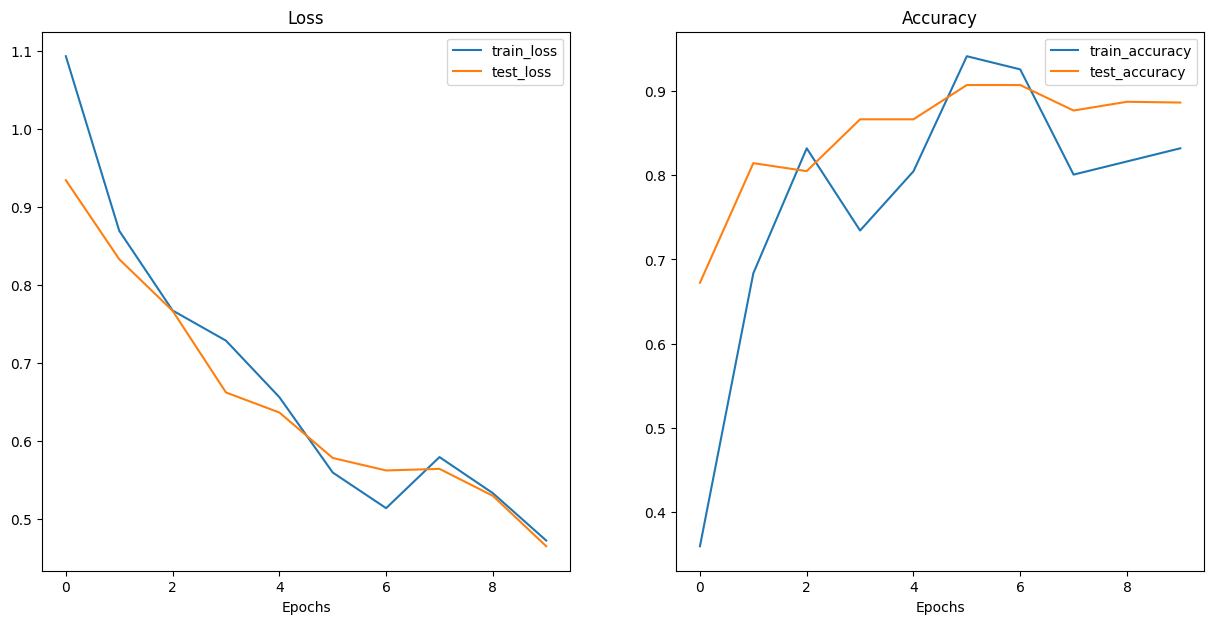

In [16]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

In [17]:
# Saving EffNetB2 feature extractor

from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_effnetb2_feature_extractor.pth")

[INFO] Saving model to: models/09_effnetb2_feature_extractor.pth


In [18]:
# Checking the size of model

from pathlib import Path

model_path = Path("models/09_effnetb2_feature_extractor.pth")
pretrained_effnetb2_model_size=model_path.stat().st_size//(1024*1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [19]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [20]:
# Dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.464927872021993,
 'test_acc': 0.8863636363636364,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

## 3. Creating a ViT feature extractor

In [21]:
vit = torchvision.models.vit_b_16()
# vit.heads()

In [22]:
def create_vit_model(num_classes:int=3,seed:int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  for param in model.parameters():
    param.requires_grad = False

  torch.manual_seed(seed)
  model.heads = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [23]:
vit,vit_transforms = create_vit_model(num_classes=3,seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 128MB/s]


In [24]:
summary(
    vit,
    input_size=(32,3,224,224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [25]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

In [26]:
#Training ViTfeature extractor

from going_modular.going_modular import engine

optimizer = optim.Adam(params=vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7768 | train_acc: 0.6992 | test_loss: 0.5612 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3794 | train_acc: 0.9180 | test_loss: 0.3352 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2297 | train_acc: 0.9414 | test_loss: 0.2830 | test_acc: 0.9290
Epoch: 4 | train_loss: 0.1641 | train_acc: 0.9570 | test_loss: 0.2517 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1322 | train_acc: 0.9766 | test_loss: 0.2329 | test_acc: 0.9186
Epoch: 6 | train_loss: 0.1399 | train_acc: 0.9688 | test_loss: 0.2184 | test_acc: 0.9186
Epoch: 7 | train_loss: 0.1155 | train_acc: 0.9648 | test_loss: 0.2389 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0875 | train_acc: 0.9844 | test_loss: 0.2253 | test_acc: 0.8883
Epoch: 9 | train_loss: 0.1564 | train_acc: 0.9766 | test_loss: 0.2013 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0815 | train_acc: 0.9805 | test_loss: 0.1756 | test_acc: 0.9176


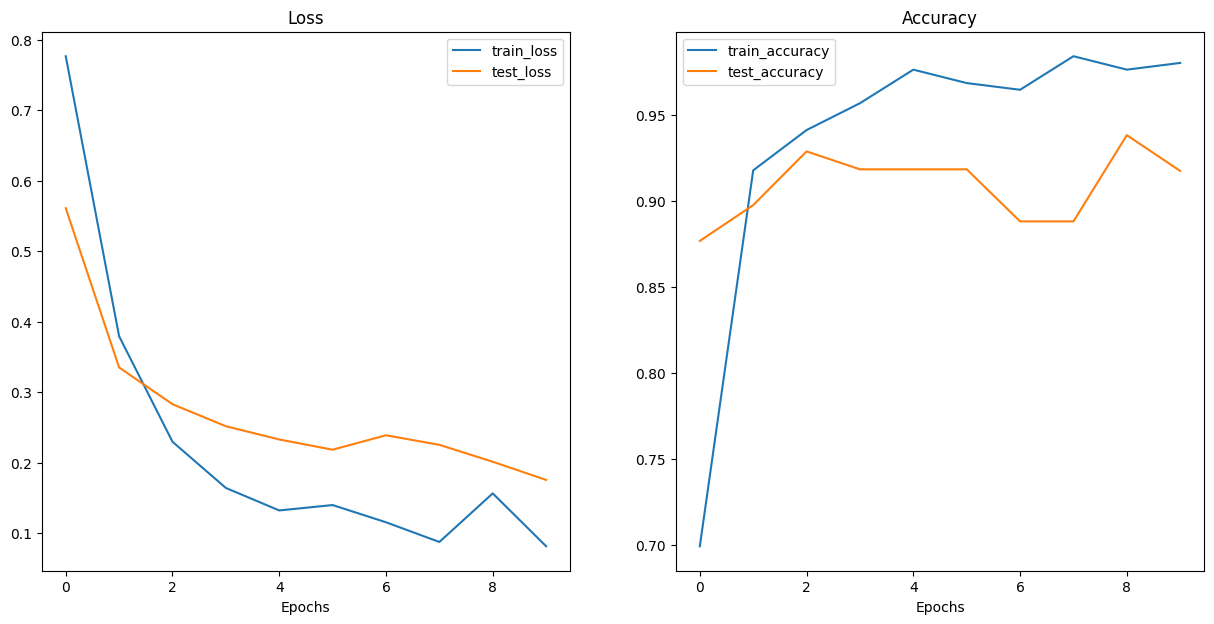

In [27]:
plot_loss_curves(vit_results)

In [28]:
#Save the model

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_vit_feature_extractor.pth")

[INFO] Saving model to: models/09_vit_feature_extractor.pth


In [29]:
model_path = Path("models/09_vit_feature_extractor.pth")
pretrained_vit_model_size=model_path.stat().st_size//(1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [30]:
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [31]:
# ViT Statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters": vit_total_params,
                  "model_size (MB)": pretrained_vit_model_size}
vit_stats

{'test_loss': 0.17558992405732474,
 'test_acc': 0.9176136363636364,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## 4. Making Predictions with trained models and timing them

In [32]:
from pathlib import Path

print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi/test


[PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg')]

In [33]:
from pickle import encode_long
import pathlib
import torch
import torchvision
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform:torchvision.transforms,
                   class_names: List[str],
                   device:str="cuda" if torch.cuda.is_available() else "cpu")->List[Dict]:


      pred_list = []

      for path in tqdm(paths):
        pred_dict = {}

        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        start_time = timer()
        img = Image.open(path)

        transformed_image = transform(img).unsqueeze(dim=0).to(device)
        model.to(device)
        model.eval()

        with torch.inference_mode():
          pred_logits = model(transformed_image)
          pred_prob = torch.softmax(pred_logits, dim=1)
          pred_label = torch.argmax(pred_prob, dim=1)
          pred_class = class_names[pred_label.cpu()]

          pred_dict["pred_class"] = pred_class
          pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)

          end_time = timer()
          pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        pred_dict["correct"] = class_name == pred_class

        pred_list.append(pred_dict)

      return pred_list


In [34]:
# Make predictions across test dataset with EffNetB2

effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/75 [00:00<?, ?it/s]

In [35]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
  'class_name': 'steak',
  'pred_class': 'pizza',
  'pred_prob': 0.3999,
  'time_for_pred': 0.3491,
  'correct': False},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/steak/1302563.jpg'),
  'class_name': 'steak',
  'pred_class': 'steak',
  'pred_prob': 0.8487,
  'time_for_pred': 0.1263,
  'correct': True}]

In [36]:
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_class,pred_prob,time_for_pred,correct
0,data/pizza_steak_sushi/test/steak/100274.jpg,steak,pizza,0.3999,0.3491,False
1,data/pizza_steak_sushi/test/steak/1302563.jpg,steak,steak,0.8487,0.1263,True
2,data/pizza_steak_sushi/test/steak/673127.jpg,steak,steak,0.8516,0.1451,True
3,data/pizza_steak_sushi/test/steak/1882831.jpg,steak,steak,0.4958,0.1484,True
4,data/pizza_steak_sushi/test/steak/2144308.jpg,steak,steak,0.5032,0.1140,True


In [37]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,66
False,9


In [38]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1247 seconds


In [39]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.464927872021993,
 'test_acc': 0.8863636363636364,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1247}